## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as scs

import spei as si

from diagnostic_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [2]:
# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
N_ENSEMBLE = 50
K = 5
donor_fdc = 'nwmv21'
hru_scaled = False

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

In [3]:
Q_reconst = pd.read_csv(f'./outputs/historic_reconstruction_daily_1960_2022_nhmv10_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

# Q_reconst = Q_reconst.loc[:'1970-01-01',:]
# Sum inflows by node
Q_reconst_nodes = pd.DataFrame(index=Q_reconst.index, columns=obs_pub_site_matches.keys())
for node in Q_reconst_nodes.columns:
    if obs_pub_site_matches[node] is not None:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, obs_pub_site_matches[node]].sum(axis=1)
    else:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, node]
Q_reconst_nodes["Total NYC Inflow"] = Q_reconst_nodes.loc[:,nyc_reservoirs].sum(axis=1)
Q_reconst_nodes["Basin Total"] = Q_reconst_nodes.sum(axis=1)

In [18]:
# Rolling sum
Q_rsum = Q_reconst.rolling("365D").sum().dropna()
Q_nodes_rsum = Q_reconst_nodes.rolling("365D").sum().dropna()

node_ssi = pd.DataFrame(index = Q_rsum.index, columns=Q_nodes_rsum.columns)
for node in node_ssi.columns:
    node_ssi[node] = si.ssfi(Q_nodes_rsum[node], dist = scs.gamma)

# cannonsville_gammfit_plot = si.plot.dist(Q_nodes_rsum['cannonsville'], scs.gamma, cumulative=True, legend = False)

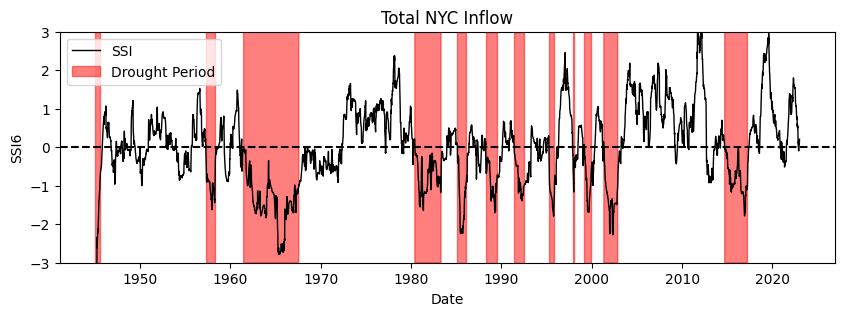

In [19]:
plot_nodes = ['Total NYC Inflow']
# plot_nodes = ['pepacton']

fig, ax = plt.subplots(nrows=len(plot_nodes), ncols=1, figsize = (10,len(plot_nodes)*3), sharex = True)
plot_ssi(node_ssi[plot_nodes[0]], ax = ax)
ax.set_title(plot_nodes[0])
plt.xlabel('Date')
plt.ylabel('SSI6')
plt.legend(loc='upper left')

Text(0.5, 0, 'Date')

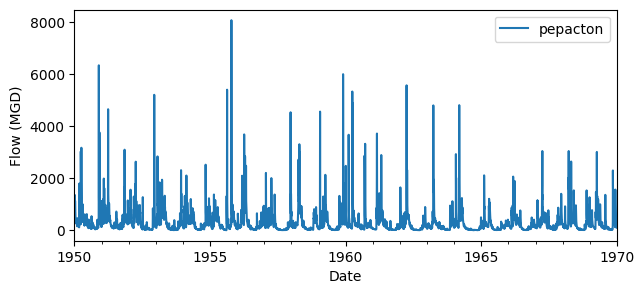

In [12]:
fig,ax = plt.subplots(figsize=(7,3))
Q_reconst_nodes.loc['1950-01-01':'1970-01-01', plot_nodes].plot(ax=ax)
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

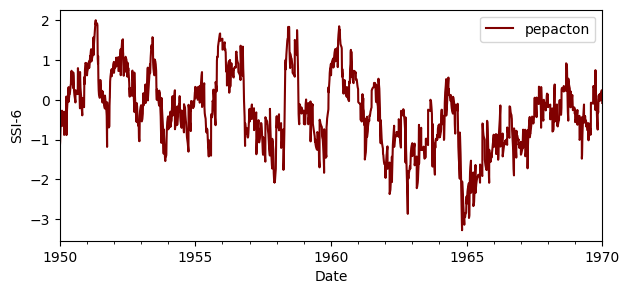

In [14]:
fig,ax = plt.subplots(figsize=(7,3))
node_ssi.loc['1950-01-01':'1970-01-01', plot_nodes].plot(ax=ax, c = 'maroon')
plt.ylabel('SSI-6')
plt.xlabel('Date')


In [13]:

drought_data = {}
drought_counter = 0
for node in plot_nodes:
    ssi = node_ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()
drought_metrics = drought_metrics.drop(1, axis=0).reset_index()
drought_metrics.head()


,index,start,end,duration,magnitude,severity,node
0,2,1946-04-02,1946-10-31,213,-115.79984,-1.229454,pepacton
1,3,1946-11-19,1947-05-15,178,-140.62612,-1.48533,pepacton
2,4,1947-11-19,1948-03-22,125,-113.187539,-1.627985,pepacton
3,5,1949-06-28,1950-03-29,275,-289.994288,-2.008966,pepacton
4,6,1951-09-08,1951-11-04,58,-23.692345,-1.183209,pepacton


NameError: name 'drought_metrics' is not defined

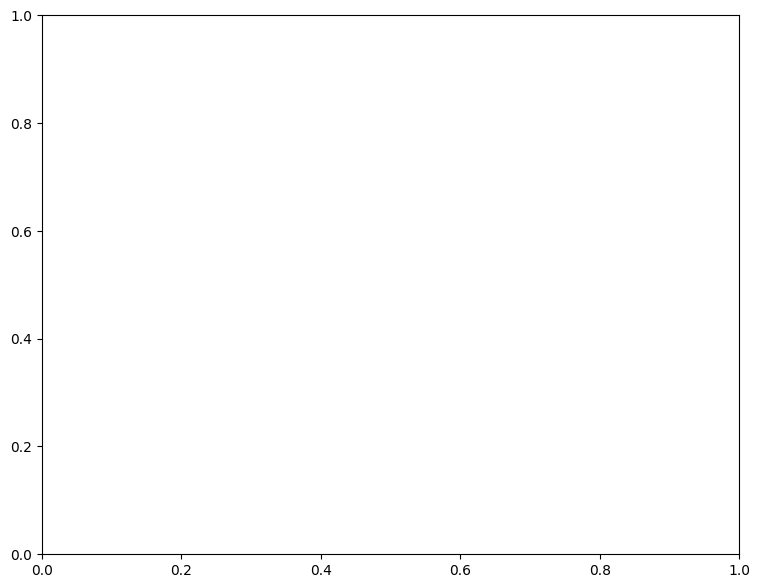

In [15]:
## Options
highlight_after_1970 = False

fig, ax = plt.subplots(figsize = (9,7))
# cmap = plt.get_cmap('Reds')
# norm = mpl.colors.Normalize(vmin=drought_metrics['severity'].min(), 
#                             vmax=drought_metrics['severity'].max())

# cs = cmap(norm(drought_metrics['severity'].values))
p = ax.scatter(drought_metrics['severity'], -drought_metrics['magnitude'],
           c= drought_metrics['duration'], cmap = 'viridis_r', s=100)

if highlight_after_1970:
    ax.scatter(drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'severity'], 
               -drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'magnitude'],
           edgecolors = 'darkorange', s=300, facecolors='none', linewidths=3,
           label = 'Droughts observed after 1970')


plt.colorbar(p).set_label(label = 'Drought Duration (days)',size=15)
plt.xlabel(r'Severity ($Minimum SSI_{6}$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
plt.title(f'Historic Droughts (1945-2022) at {plot_nodes[0].capitalize()}', fontsize = 16)
plt.legend(fontsize=14)
plt.show()

# plt.yscale('log')
# plt.xscale('log')